In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy
import numpy as np
import openpyxl


# 1. Load Raw Data
csv_raw = pd.read_csv("./data/data.csv", skiprows=1, parse_dates=['datetime'], dayfirst=False)

# 2. extract usable raw component(columns) ordered by datatime
raw_data = csv_raw[['datetime', 'warmup', 'off', 
                   'add_amount_brightener', 'add_amount_carrier', 
                   'velocity','tension','v','a','temperature',
                   'copper_sulfate_content', 'sulfuric_acid_content', 'chloride_content']].sort_values("datetime")

# 3. extracted column data
raw_warmup = raw_data[~raw_data["warmup"].isna()][["datetime", "warmup"]]
raw_off = raw_data[~raw_data["off"].isna()][["datetime", "off"]]
raw_brightener = (raw_data[~raw_data["add_amount_brightener"].isna()])[["datetime", "add_amount_brightener"]]
raw_carrier = (raw_data[~raw_data["add_amount_carrier"].isna()])[["datetime", "add_amount_carrier"]]
raw_velocity = (raw_data[~raw_data["velocity"].isna()])[["datetime", "velocity"]]
raw_tension = (raw_data[~raw_data["tension"].isna()])[["datetime", "tension"]]
raw_voltage = (raw_data[~raw_data["v"].isna()])[["datetime", "v"]]
raw_ampere = (raw_data[~raw_data["a"].isna()])[["datetime", "a"]]
raw_temperature = (raw_data[~raw_data["temperature"].isna()])[["datetime", "temperature"]]
raw_cs = (raw_data[~raw_data["copper_sulfate_content"].isna()])[["datetime", "copper_sulfate_content"]]
raw_sa = (raw_data[~raw_data["sulfuric_acid_content"].isna()])[["datetime", "sulfuric_acid_content"]]
raw_c = (raw_data[~raw_data["chloride_content"].isna()])[["datetime", "chloride_content"]]

#4. Create new data frame (for every single day operation)
raw_ext = pd.DataFrame(dtype=float, columns=['datetime', 'optime', 'optime_min', 'add_amount_brightener', 'add_amount_carrier', 
                                             'velocity_mean', 'velocity_var', 'velocity_std',
                                             'tension_mean','tension_var', 'tension_std',
                                             'voltage_mean','voltage_var', 'voltage_std',
                                             'ampere_mean','ampere_var', 'ampere_std',
                                             'temperature_mean','temperature_var', 'temperature_std',
                                             'cs_mean','cs_var', 'cs_std',
                                             'sa_mean','sa_var', 'sa_std',
                                             'c_mean','c_var', 'c_std'])

#5. Calculate operation time (every single day)
for warmup, off in zip(raw_warmup.iterrows(), raw_off.iterrows()):
    value = [off[1]["datetime"], off[1]["datetime"]-warmup[1]["datetime"]]
    value.extend([np.nan for i in range(0, raw_ext.shape[1]-len(value))])
    raw_ext.loc[len(raw_ext.index)] = value

raw_ext = raw_ext.groupby(pd.Grouper(key='datetime', freq='D', sort=True)).sum()
raw_ext = raw_ext[raw_ext["optime"]!=datetime.timedelta(seconds=0)] # drop no timedelta
raw_ext["optime_min"] = [i.total_seconds()/60 for i in raw_ext.loc[:,"optime"]] # add time min
raw_ext = raw_ext.drop(columns="optime")


#6. update all data corresponding to optime date
for t_idx in raw_ext.index:
    mask_brightener = list((raw_brightener["datetime"]>t_idx) & (raw_brightener["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_carrier = list((raw_carrier["datetime"]>t_idx) & (raw_carrier["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_voltage = list((raw_voltage["datetime"]>t_idx) & (raw_voltage["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_ampere = list((raw_ampere["datetime"]>t_idx) & (raw_ampere["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_temperature = list((raw_temperature["datetime"]>t_idx) & (raw_temperature["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_tension = list((raw_tension["datetime"]>t_idx) & (raw_tension["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_velocity = list((raw_velocity["datetime"]>t_idx) & (raw_velocity["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_cs = list((raw_cs["datetime"]>t_idx) & (raw_cs["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_sa = list((raw_sa["datetime"]>t_idx) & (raw_sa["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    mask_c = list((raw_c["datetime"]>t_idx) & (raw_c["datetime"]<=t_idx+datetime.timedelta(hours=24)))
    
    if any(mask_brightener):
        raw_ext.loc[t_idx, "add_amount_brightener"] = raw_brightener.loc[mask_brightener, "add_amount_brightener"].values[0]
    if any(mask_carrier):
        raw_ext.loc[t_idx, "add_amount_carrier"] = raw_carrier.loc[mask_carrier, "add_amount_carrier"].values[0]
    if any(mask_voltage):
        raw_ext.loc[t_idx, "voltage_mean"] = raw_voltage.loc[mask_voltage, "v"].values.mean()
        raw_ext.loc[t_idx, "voltage_var"] = raw_voltage.loc[mask_voltage, "v"].values.var()
        raw_ext.loc[t_idx, "voltage_std"] = raw_voltage.loc[mask_voltage, "v"].values.std()
    if any(mask_ampere):
        raw_ext.loc[t_idx, "ampere_mean"] = raw_ampere.loc[mask_voltage, "a"].values.mean()
        raw_ext.loc[t_idx, "ampere_var"] = raw_ampere.loc[mask_voltage, "a"].values.var()
        raw_ext.loc[t_idx, "ampere_std"] = raw_ampere.loc[mask_voltage, "a"].values.std()
    if any(mask_temperature):
        raw_ext.loc[t_idx, "temperature_mean"] = raw_temperature.loc[mask_temperature, "temperature"].values.mean()
        raw_ext.loc[t_idx, "temperature_var"] = raw_temperature.loc[mask_temperature, "temperature"].values.var()
        raw_ext.loc[t_idx, "temperature_std"] = raw_temperature.loc[mask_temperature, "temperature"].values.std()
    if any(mask_cs):
        raw_ext.loc[t_idx, "cs_mean"] = raw_cs.loc[mask_cs, "copper_sulfate_content"].values.mean()
        raw_ext.loc[t_idx, "cs_var"] = raw_cs.loc[mask_cs, "copper_sulfate_content"].values.var()
        raw_ext.loc[t_idx, "cs_std"] = raw_cs.loc[mask_cs, "copper_sulfate_content"].values.std()
    if any(mask_sa):
        raw_ext.loc[t_idx, "sa_mean"] = raw_sa.loc[mask_sa, "sulfuric_acid_content"].values.mean()
        raw_ext.loc[t_idx, "sa_var"] = raw_sa.loc[mask_sa, "sulfuric_acid_content"].values.var()
        raw_ext.loc[t_idx, "sa_std"] = raw_sa.loc[mask_sa, "sulfuric_acid_content"].values.std()
    if any(mask_c):
        raw_ext.loc[t_idx, "c_mean"] = raw_c.loc[mask_cs, "chloride_content"].values.mean()
        raw_ext.loc[t_idx, "c_var"] = raw_c.loc[mask_cs, "chloride_content"].values.var()
        raw_ext.loc[t_idx, "c_std"] = raw_c.loc[mask_cs, "chloride_content"].values.std()
    if any(mask_velocity):
        raw_ext.loc[t_idx, "velocity_mean"] = raw_velocity.loc[mask_velocity, "velocity"].values.mean()
        raw_ext.loc[t_idx, "velocity_var"] = raw_velocity.loc[mask_velocity, "velocity"].values.var()
        raw_ext.loc[t_idx, "velocity_std"] = raw_velocity.loc[mask_velocity, "velocity"].values.std()
    if any(mask_tension):
        raw_ext.loc[t_idx, "tension_mean"] = raw_tension.loc[mask_tension, "tension"].values.mean()
        raw_ext.loc[t_idx, "tension_var"] = raw_tension.loc[mask_tension, "tension"].values.var()
        raw_ext.loc[t_idx, "tension_std"] = raw_tension.loc[mask_tension, "tension"].values.std()
        
# 7. drop the row with nan value of add_amount_brightener
raw_prepared = raw_ext.loc[raw_ext["add_amount_brightener"]!=0.0]

# 7.1 save to csv file
raw_prepared.to_csv('./aggregate.csv', sep=',')
raw_prepared.head()

# 8. resampling by multivariate Gaussian Distribution
# 시계열 데이터의 특성이 시간에 대한 독립성을 가정하는것이 문제가 있을것 같지만, 우선 독립성을 가정해서 리샘플링
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal

# 8.1 data normalization
enable_normalization = False
# normalization
if enable_normalization==True:
    optime_scaler = StandardScaler()
    brightener_scaler = StandardScaler()
    carrier_scaler = StandardScaler()
    voltage_scaler = StandardScaler()
    ampere_scaler = StandardScaler()
    temperaature_scaler = StandardScaler()
    cs_scaler = StandardScaler()
    sa_scaler = StandardScaler()
    c_scaler = StandardScaler()
    velocity_scaler = StandardScaler()
    tension_scaler = StandardScaler()
    optime_mean_normalized = optime_scaler.fit_transform(raw_prepared.loc[:,"optime_min"].ravel().reshape(-1, 1)).flatten()
    add_amount_brightener_normalized = brightener_scaler.fit_transform(raw_prepared.loc[:,"add_amount_brightener"].ravel().reshape(-1, 1)).flatten()
    add_amount_carrier_normalized = carrier_scaler.fit_transform(raw_prepared.loc[:,"add_amount_carrier"].ravel().reshape(-1, 1)).flatten()
    voltage_normalized = voltage_scaler.fit_transform(raw_prepared.loc[:,"voltage_mean"].ravel().reshape(-1, 1)).flatten()
    ampere_normalized = ampere_scaler.fit_transform(raw_prepared.loc[:,"ampere_mean"].ravel().reshape(-1, 1)).flatten()
    temperature_normalized = temperaature_scaler.fit_transform(raw_prepared.loc[:,"temperature_mean"].ravel().reshape(-1, 1)).flatten()
    cs_normalized = cs_scaler.fit_transform(raw_prepared.loc[:,"cs_mean"].ravel().reshape(-1, 1)).flatten()
    sa_normalized = sa_scaler.fit_transform(raw_prepared.loc[:,"sa_mean"].ravel().reshape(-1, 1)).flatten()
    c_normalized = c_scaler.fit_transform(raw_prepared.loc[:,"c_mean"].ravel().reshape(-1, 1)).flatten()
    velocity_normalized = velocity_scaler.fit_transform(raw_prepared.loc[:,"velocity_mean"].ravel().reshape(-1, 1)).flatten()
    tension_normalized = tension_scaler.fit_transform(raw_prepared.loc[:,"tension_mean"].ravel().reshape(-1, 1)).flatten()
else:
    # without normalization
    optime_mean_normalized = raw_prepared.loc[:,"optime_min"].ravel()
    add_amount_brightener_normalized = raw_prepared.loc[:,"add_amount_brightener"].ravel()
    add_amount_carrier_normalized = raw_prepared.loc[:,"add_amount_carrier"].ravel()
    voltage_normalized = raw_prepared.loc[:,"voltage_mean"].ravel()
    ampere_normalized = raw_prepared.loc[:,"ampere_mean"].ravel()
    temperature_normalized = raw_prepared.loc[:,"temperature_mean"].ravel()
    cs_normalized = raw_prepared.loc[:,"cs_mean"].ravel()
    sa_normalized = raw_prepared.loc[:,"sa_mean"].ravel()
    c_normalized = raw_prepared.loc[:,"c_mean"].ravel()
    velocity_normalized = raw_prepared.loc[:,"velocity_mean"].ravel()
    tension_normalized = raw_prepared.loc[:,"tension_mean"].ravel()

# if you need inverse transform
# test_scaler = StandardScaler()
# test_optime_mean_normalized = test_scaler.fit_transform(raw_prepared.loc[:,"optime_min"].ravel().reshape(-1, 1))
# inv = test_scaler.inverse_transform(test_optime_mean_normalized)
# print(inv)
# print(raw_prepared.loc[:,"optime_min"].ravel())

# for test ploting
# data = pd.DataFrame(raw_prepared.loc[:,"add_amount_brightener"].ravel(), columns = ['Optime'])
# data.plot.kde(bw_method="silverman")
# plt.title('Data Distribution', fontsize=15)
# plt.show()

source = np.array([
    optime_mean_normalized.mean(),
    add_amount_brightener_normalized.mean(),
    add_amount_carrier_normalized.mean(),
    voltage_normalized.mean(),
    ampere_normalized.mean(),
    temperature_normalized.mean(),
    cs_normalized.mean(),
    sa_normalized.mean(),
    c_normalized.mean(),
    velocity_normalized.mean(),
    tension_normalized.mean()]
)

# data normalization for computing covariance matrix
source_cov = np.cov(source, rowvar=False)
resampled = multivariate_normal.rvs(mean=source, cov=source_cov, size=500000)
resampled = resampled[~np.any(resampled<=0, axis=1)]




In [16]:
# Linearity Verification
pearson_correlation = np.corrcoef(resampled[:,0], resampled[:,2])[0, 1]
print(f"Pearson Correlation Coefficient: {pearson_correlation}")

Pearson Correlation Coefficient: 0.003002351428127725


In [ ]:

# model : output = [brightener, carrier], input=[else]
# modeling with Support Vector Regression
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


# for multivariate output
enable_multioutput = True

if enable_multioutput:
    X = resampled[:, [0,3,4,5,6,7,8,9,10]]
    y = resampled[:, [1,2]] # brightener, carrier
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    svr = SVR(kernel='rbf', C=100, gamma='auto', epsilon=0.01)

    multioutput_svr = MultiOutputRegressor(svr)
    multioutput_svr.fit(X_train, y_train)
    y_pred = multioutput_svr.predict(X_test)
    plt.scatter(y_test[:, 0], y_pred[:, 0], color='darkorange', label='brightener')
    plt.scatter(y_test[:, 1], y_pred[:, 1], color='navy', label='carrier')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Support Vector Regression with Multivariate Outputs')
    plt.legend()
    plt.show()

    r2 = r2_score(y_test, y_pred)
    print(f"R-squared Result : {r2}")

else:
    X = resampled[:, [6,7]]
    y = resampled[:, [1]] # brightener, carrier
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    svr = SVR(kernel='rbf', C=1000, gamma='auto', epsilon=0.01)
    print(X_test)
    
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    plt.scatter(y_test, y_pred, color='darkorange', label='data')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Support Vector Regression with Multivariate Outputs')
    plt.legend()
    plt.show()

    r2 = r2_score(y_test, y_pred)
    print(f"R-squared Result : {r2}")
    

# print("Train data shape : ", X_train.shape, y_train.shape)

Epoch 1/10
1487/1487 [==============================] - 3s 1ms/step - loss: 13723.2627
Epoch 2/10
1487/1487 [==============================] - 2s 2ms/step - loss: 13212.4658
Epoch 3/10
1487/1487 [==============================] - 3s 2ms/step - loss: 13156.8945
Epoch 4/10
1487/1487 [==============================] - 3s 2ms/step - loss: 13051.7334
Epoch 5/10
1487/1487 [==============================] - 3s 2ms/step - loss: 13023.5459
Epoch 6/10
1487/1487 [==============================] - 2s 1ms/step - loss: 12970.4453
Epoch 7/10
1487/1487 [==============================] - 2s 1ms/step - loss: 12923.0830
Epoch 8/10
1487/1487 [==============================] - 2s 1ms/step - loss: 12877.1865
Epoch 9/10
1487/1487 [==============================] - 3s 2ms/step - loss: 12834.0938
Epoch 10/10
100/100 [==============================] - 0s 718us/step


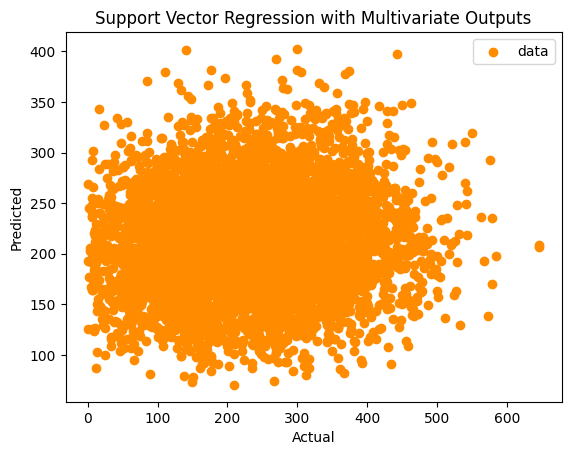

R-squared Result : -0.24362503711742822


In [14]:
# multivariate multi layer perceptron
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

X = resampled[:, [0,6,7,8,9]]
y = resampled[:, [1,2]] # brightener, carrier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 모델 구축
model = Sequential([
    Dense(10, input_shape=(X.shape[1],), activation='relu'),
    Dense(5, activation='relu'),
    Dense(2)
])

# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=5)
y_pred = model.predict(X_test)

plt.scatter(y_test, y_pred, color='darkorange', label='data')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Support Vector Regression with Multivariate Outputs')
plt.legend()
plt.show()
    
r2 = r2_score(y_test, y_pred)
print(f"R-squared Result : {r2}")

